In [ ]:
# -------------------------------------------------
#             Вернель Павел КЭ-404
# -------------------------------------------------
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler, ADASYN

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

from sklearn.tree import export_graphviz
import graphviz

from google.colab import drive

column_names = {
    0: "age",
    1: "workclass",
    2: "fnlwgt",
    3: "education",
    4: "education-num",
    5: "marital-status",
    6: "occupation",
    7: "relationship",
    8: "race",
    9: "sex",
    10: "capital-gain",
    11: "capital-loss",
    12: "hours-per-week",
    13: "native-country",
    14: "income"
}

In [ ]:
drive.mount('/content/drive')
train_file = '/content/drive/My Drive/Анализ/train.csv'
test_file = '/content/drive/My Drive/Анализ/test.csv'

train = pd.read_csv(train_file, header=None)
test = pd.read_csv(test_file, header=None)

train.rename(columns=column_names, inplace=True)
test.rename(columns=column_names, inplace=True)
test['income'] = test['income'].str.rstrip('.')

dataset = pd.concat([train, test])

print("Количество записей с значением  <=50K  --> ", len(dataset[dataset['income'] == ' <=50K']))
print("Количество записей с значением  >50K  --> ", len(dataset[dataset['income'] == ' >50K']))

dataset

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Количество записей с значением  <=50K  -->  37155
Количество записей с значением  >50K  -->  11687


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16276,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K
16277,64,?,321403,HS-grad,9,Widowed,?,Other-relative,Black,Male,0,0,40,United-States,<=50K
16278,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K
16279,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K


In [ ]:
# Метрики
def classification_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label=1)
    recall = recall_score(y_true, y_pred, pos_label=1)
    f1 = f1_score(y_true, y_pred, pos_label=1)
    return accuracy, precision, recall, f1


# Балансировка датасета
def balance_dataset(dataset):
    # Разделение на признаки и метки
    X = dataset.drop(columns=['income'])
    y = dataset['income']

    # Преобразование меток классов в числовые значения (0 и 1)
    y_numeric = (y == ' >50K').astype(int)

    # Создание экземпляра RandomOverSampler
    ros = RandomOverSampler(random_state=42)

    # Применение RandomOverSampler к данным
    X_resampled, y_resampled = ros.fit_resample(X, y_numeric)

    # Преобразование обратно в DataFrame
    X_balanced = pd.DataFrame(X_resampled, columns=X.columns)
    y_balanced = pd.Series(y_resampled)

    # Объединение признаков и меток обратно в DataFrame
    balanced_dataset = pd.concat([X_balanced, y_balanced], axis=1)
    balanced_dataset['income'] = balanced_dataset['income'].map({0: ' <=50K', 1: ' >50K'})

    return balanced_dataset

# Обучения дерева решений
def classify_dataset(dataset, ensemble_technique='random_forest', n_estimators=100, max_depth=15, test_size=0.2):
    balanced_dataset = balance_dataset(dataset)

    # Преобразование категориальных признаков в числовые с помощью LabelEncoder
    dataset_encoded = balanced_dataset.copy()
    label_encoder = LabelEncoder()
    for column in dataset_encoded.select_dtypes(include=['object']).columns:
        dataset_encoded[column] = label_encoder.fit_transform(dataset_encoded[column])

    # Разделение на признаки и метки
    X = dataset_encoded.drop(columns=['income'])
    y = dataset_encoded['income']

    # Разделение на обучающий и тестовый наборы
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # Создание и обучение модели в зависимости от выбранной техники ансамблевой классификации
    if ensemble_technique == 'random_forest':
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    elif ensemble_technique == 'bagging':
        base_model = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
        model = BaggingClassifier(base_model, n_estimators=n_estimators, random_state=42)
    elif ensemble_technique == 'boosting':
        model = GradientBoostingClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    else:
        raise ValueError("Нужно выбрать ансамблевый метод из списка: 'random_forest', 'bagging', 'boosting'")

    model.fit(X_train, y_train)

    # Предсказание на тестовом наборе
    y_pred = model.predict(X_test)

    # Вычисление показателей качества классификации
    accuracy, precision, recall, f1 = classification_metrics(y_test, y_pred)

    return model, accuracy, precision, recall, f1, X_train, y_train

In [ ]:
model, accuracy, precision, recall, f1, X_train, y_train = classify_dataset(dataset, ensemble_technique='random_forest',
                                                                            n_estimators=150, max_depth=15, test_size=0.2)

print(f"Метрики:\n" +
        f"Accuracy: {accuracy:.2f}\n" +
        f"Precision: {precision:.2f}\n" +
        f"Recall: {recall:.2f}\n" +
        f"F1: {f1:.2f}"
      )

Метрики:
Accuracy: 0.87
Precision: 0.83
Recall: 0.93
F1: 0.88


In [ ]:
# Создание списка значений для количества участников ансамбля
n_estimators_values = list(range(50, 101, 10))

# Списки для хранения результатов экспериментов
accuracies = []
precisions = []
recalls = []
f1_scores = []

# Цикл по значениям количества участников ансамбля
for n_estimators in n_estimators_values:
    # Выполнение классификации для текущего значения количества участников ансамбля
    _, accuracy, precision, recall, f1, _, _ = classify_dataset(dataset, ensemble_technique='random_forest', n_estimators=n_estimators, max_depth=15, test_size=0.2)

    # Добавление результатов в соответствующие списки
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)


+----+----------------+------------+-------------+----------+------------+
|    |   n_estimators |   Accuracy |   Precision |   Recall |   F1-score |
+====+================+============+=============+==========+============+
|  0 |             50 |     0.8736 |      0.8325 |   0.9325 |     0.8797 |
+----+----------------+------------+-------------+----------+------------+
|  1 |             60 |     0.8729 |      0.8318 |   0.9321 |     0.8791 |
+----+----------------+------------+-------------+----------+------------+
|  2 |             70 |     0.8725 |      0.8303 |   0.9336 |     0.8789 |
+----+----------------+------------+-------------+----------+------------+
|  3 |             80 |     0.873  |      0.8313 |   0.9332 |     0.8793 |
+----+----------------+------------+-------------+----------+------------+
|  4 |             90 |     0.8736 |      0.832  |   0.9335 |     0.8798 |
+----+----------------+------------+-------------+----------+------------+
|  5 |            100 |  

In [ ]:
# Вывод результатов
from tabulate import tabulate

results_df = pd.DataFrame({
    "n_estimators": n_estimators_values,
    "Accuracy": accuracies,
    "Precision": precisions,
    "Recall": recalls,
    "F1-score": f1_scores
})

results_df = results_df.round(4)
print(tabulate(results_df, headers='keys', tablefmt='grid'))

+----+----------------+------------+-------------+----------+------------+
|    |   n_estimators |   Accuracy |   Precision |   Recall |   F1-score |
+====+================+============+=============+==========+============+
|  0 |             50 |     0.8736 |      0.8325 |   0.9325 |     0.8797 |
+----+----------------+------------+-------------+----------+------------+
|  1 |             60 |     0.8729 |      0.8318 |   0.9321 |     0.8791 |
+----+----------------+------------+-------------+----------+------------+
|  2 |             70 |     0.8725 |      0.8303 |   0.9336 |     0.8789 |
+----+----------------+------------+-------------+----------+------------+
|  3 |             80 |     0.873  |      0.8313 |   0.9332 |     0.8793 |
+----+----------------+------------+-------------+----------+------------+
|  4 |             90 |     0.8736 |      0.832  |   0.9335 |     0.8798 |
+----+----------------+------------+-------------+----------+------------+
|  5 |            100 |  

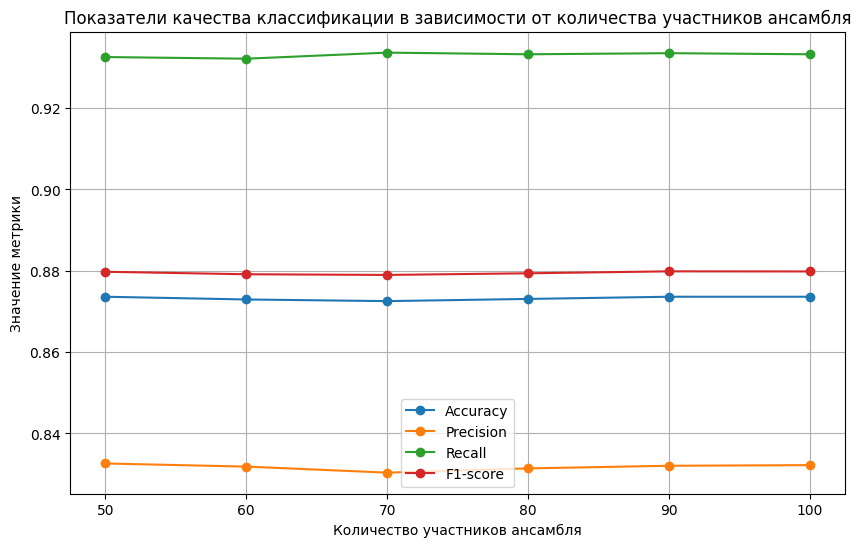

In [ ]:
# Графическая настройка
plt.figure(figsize=(10, 6))
plt.title('Показатели качества классификации в зависимости от количества участников ансамбля')
plt.xlabel('Количество участников ансамбля')
plt.ylabel('Значение метрики')

# Построение графиков для каждой метрики
plt.plot(n_estimators_values, accuracies, label='Accuracy', marker='o')
plt.plot(n_estimators_values, precisions, label='Precision', marker='o')
plt.plot(n_estimators_values, recalls, label='Recall', marker='o')
plt.plot(n_estimators_values, f1_scores, label='F1-score', marker='o')

# Добавление легенды
plt.legend()

# Отображение графика
plt.grid(True)
plt.show()
